# Regularization

In practice, many networks we will encounter in network machine learning will *not* be simple networks. As we discussed in the preceding discussion, many of the techniques we discuss will be just fine to use with weighted networks. Unfortunately, real world networks are often extremely noisy, and so the analysis of one real world network might not generalize very well to a similar real world network. For this reason, we turn to *regularization*. **Regularization** is defined as, "the process of adding information in order to solve an ill-posed problem or to prevent overfitting." In network machine learning, what this usually will entail is modifying the network (or networks) themselves to allow better generalization of our statistical inference to new datasets. For each section, we'll pose an example, a simulation, and code for how to implement the desired regularization approach. It is important to realize that you might use several of these techniques simultaneously in practice, or you might have a reason to use these techniques that go outside of our working examples.

To start this section off, we're going to introduce an example that's going to be fundamental in many future sections we see in this book. We have a group of $50$ local students who attend a school in our area. The first $25$ of the students polled are athletes, and thhhe second $25$ of the students polled are in marching band. We want to analyze how good of friends the students are, and to do so, we will use network machine learning. The nodes of the network will be the students. Next, we will describe how the two networks are collected:

1. To collect the first network, we ask each student to select from a list of $50$ school activities and outside hobbies that they enjoy. For a pair of students $i$ and $j$, the weight of their interest alignment will be a score between $0$ and $50$ indicating how many activities or hobbies that they have in common. We will refer to this network as the common interests network. This network is obviously undirected, since if student $i$ shares $x$ activities or hobbies with student $j$, then student $j$ also shares $x$ activities or hobbies with student $i$. This network is weighted, since the score is between $0$ and $50$. Finally, this network is loopless, because it would not make sense to look at the activity/hobby alignment of a student with themself, since this number would be largely uninformative as every student would have perfect alignment of activities and hobbies with him or herself. 
2. To collect the second network, we ask each student to rate how good of friends they are with other students, on a scale from $0$ to $1$. A score of $0$ means they are not friends with the student or do not know the student, and a score of $1$ means the student is their best friend. We will refer to this network as the friendship network. This nework is clearly directed, since two students may differ on their understanding of how good of friends they are. This network is weighted, since the score is between $0$ and $1$. Finally, this network is also loopless, because it would not make sense to ask somebody how good of friends they are with themself.

Our scientific question of interest is how well activities and hobbies align with perceived notions of friendship. We want to use the preceding networks to learn about a hypothetical third network, a network whose nodes are identical to the two networks above, but whose edges are whether the two individuals are friends (or not) on facebook. To answer this question, we have quite the job to do to make our networks better suited to the task! We begin by simulating some example data, shown below as adjacency matrix heatmaps:

In [123]:
from graspologic.simulations import sbm
import numpy as np

wtargsa = [[dict(n=50, p=.09), dict(n=50, p=.02)],
          [dict(n=50, p=.02), dict(n=50, p=.06)]]

wtargsf = [[dict(a=4, b=2), dict(a=2, b=5)],
          [dict(a=2, b=5), dict(a=6, b=2)]]

# human brain network
A_activity = sbm(n=[25, 25], p=[[1,1], [1,1]], wt=np.random.binomial, wtargs=wtargsa, loops=False, directed=False)

# alien brain network
A_friend = sbm(n=[25, 25], p=[[.8, .4], [.4, 1]], wt=np.random.beta, wtargs=wtargsf, directed=True)

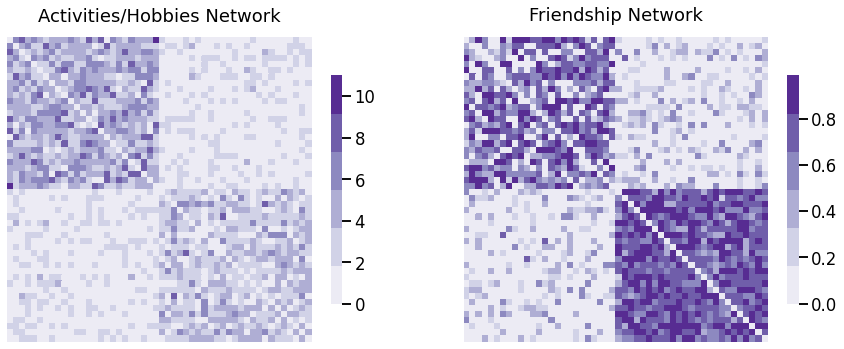

In [124]:
from graspologic.simulations import sbm
from matplotlib import pyplot as plt
from graphbook_code import heatmap

fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(A_activity, ax=axs[0], title="Activities/Hobbies Network")
heatmap(A_friend, ax=axs[1], title="Friendship Network")
fig;

## Regularization of the Nodes

### Degree trimming removes nodes with low degree

## Regularizing the Edges

### Symmetrizing the network gives us undirectedness

If we wanted to learn from the friendship network about whether two people were friends on facebook, a reasonable first place to start might be to *symmetrize* the friendship network. The facebook network is *undirected*, which means that if a student $i$ is friends on facebook with student $j$, then student $j$ is also friends with student $i$. On the other hand, as we learned above, the friendship network was directed. Since our question of interest is about an undirected network but the network we have is directed, it might be useful if we could take the directed friendship network and learn an undirected network from it. This relates directly to the concept of *interpretability*, in that we need to represent our friendship network in a form that will produce an answer or us about our facebook network which we can understand.

Another reason we might seek to symmetrize the friendship network is that we might think that asymmetries that exist in the network are just *noise*. We might assume that the adjacency entries $a_{ij}$ and $a_{ji}$ relate to one another, so together they might be able to produce a single summary number that better summarizes their relationship all together. 

Remember that in a symmetric network, $a_{ij} = a_{ji}$, so in an *asymmetric* network, $a_{ij} \neq a_{ji}$. To symmetrize the friendship network, what we want is a *new* adjacency value, which we will call $w_{ij}$, which will be a function of $a_{ij}$ and $a_{ji}$. Then, we will construct a new adjacency matrix $A'$, where each entry $a_{ij}'$ *and* $a_{ji}'$ are set equal to $w_{ij}$.  The little apostrophe just signifies that this is a potentially different value than either $a_{ij}$ or $a_{ji}$. Note that by construction, $A'$ is in fact symmetric, because $a_{ij}' = a_{ji}'$ due to how we built $A'$. 

#### Ignoring a "triangle" of the adjacency matrix

The easiest way to symmetrize a network $A$ is to just ignore part of it entirely. In the adjacency matrix $A$, you will remember that we have an upper and a lower triangular part of the matrix:
\begin{align*}
    A &= \begin{bmatrix}
        a_{11} & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{blue}{a_{21}} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{blue}{\vdots} &\color{blue}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{blue}{a_{n1}} & \color{blue}{...} & \color{blue}{a_{n,n-1}} & a_{nn}
    \end{bmatrix},
\end{align*}
The entries which are listed in <font color="red">red</font> are called the **upper right triangle of the adjacency matrix above the diagonal**. You will notice that for the entries in the upper right triangle of the adjacency matrix, $a_{ij}$ is such that $j$ is *always* greater than $i$. Similarly, the entries which are listed in <font color="blue">blue</font> are called the **lower left triangle of the adjacency matrix below the diagonal**. In the lower left triangle, $i$ is *always* greater than $j$. These are called *triangles* because of the shape they make when you look at them in matrix form: notice, for instance, that in the upper right triangle, we have a triangle with three corners of values: $a_{12}$, $a_{1n}$, and $a_{n-1, n}$.

So, how do we ignore a triangle all-together? Well, it's really quite simple! We will visually show how to ignore the lower left triangle of the adjacency matrix. We start by forming a triangle matrix, $\Delta$, as follows:
\begin{align*}
    \Delta &= \begin{bmatrix}
        0 & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{blue}{0} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{blue}{\vdots} &\color{blue}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{blue}{0} & \color{blue}{...} & \color{blue}{0} & 0
    \end{bmatrix},
\end{align*}
Notice that this matrix *keeps* all of the upper right triangle of the adjacency matrix above the diagonal the same as in the matrix $A$, but replaces the lower left triangle of the adjacency matrix below the diagonal and the diagonal with $0$s. Notice that the transpose of $\Delta$ is the matrix:
\begin{align*}
    \Delta^\top &= \begin{bmatrix}
        0 & \color{blue}{0} & \color{blue}{...} &\color{blue}{0}\\
        \color{red}{a_{12}}& \ddots & \color{blue}{\ddots} & \color{blue}{\vdots} \\
        \color{red}{\vdots}&\color{red}{\ddots} & \ddots & \color{blue}{0} \\
        \color{red}{a_{1n}}&\color{red}{...} &\color{red}{a_{n-1,n}} & 0
    \end{bmatrix}
\end{align*}
So when we add the two together, we get this:
\begin{align*}
    \Delta + \Delta^\top &= \begin{bmatrix}
        0 & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{red}{a_{12}} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{red}{\vdots}&\color{red}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{red}{a_{1n}}&\color{red}{...} &\color{red}{a_{n-1,n}} & 0
    \end{bmatrix},
\end{align*}
We're almost there! We just need to add back the diagonal of $A$, which we will do using the matrix $diag(A)$ which has values $diag(A)_{ii} = a_{ii}$, and $diag(A)_{ij} = 0$ for any $i \neq j$:
\begin{align*}
    A' &= \Delta + \Delta^\top + diag(A) = \begin{bmatrix}
        a_{11} & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{red}{a_{12}} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{red}{\vdots}&\color{red}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{red}{a_{1n}}&\color{red}{...} &\color{red}{a_{n-1,n}} & a_{nn}
    \end{bmatrix},
\end{align*}
Which leaves $A'$ to be a matrix consisting *only* of entries which were in the upper right triangle of $A$. $A'$ is obviously symmetric, because $a_{ij}' = a_{ji}'$ for all $i$ and $j$. Since the adjacency matrix is symmetric, the network $A'$ represents is undirected.

So what does this mean in terms of the network itself? What this means is that the network originally had edge weights $a_{ij}$, where $a_{ij}$ might not be equal to $a_{ji}$. This means student $i$ might perceive their friendship with student $j$ as being stronger or weaker than student $j$ perceived about student $i$. What we did here was we basically just ignored any perceived friendships $a_{ji}$ when $j$ exceeded $i$ (the lower left triangle), and simply "replaced" that perceived friendship with the corresponding entry $a_{ij}$ in the upper right triangle of the adjacency matrix. This produced for us a single friendship strength $a_{ij}'$ where $a_{ij}' = a_{ji}'$.

In graspologic, we can implement this as follows:

In [125]:
from graspologic.utils import symmetrize

# symmetrize with upper right triangle
A_friend_upright_sym = symmetrize(A_friend, method="triu")

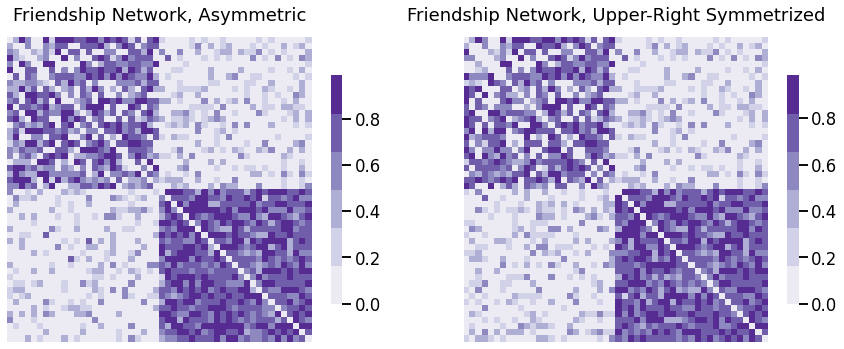

In [126]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(A_friend, ax=axs[0], title="Friendship Network, Asymmetric")
heatmap(A_friend_upright_sym, ax=axs[1], title="Friendship Network, Upper-Right Symmetrized")
fig;

Likewise, we can lower-left symmetrize as well:

In [127]:
# symmetrize with lower left triangle
A_friend_lowleft_sym = symmetrize(A_friend, method="tril")

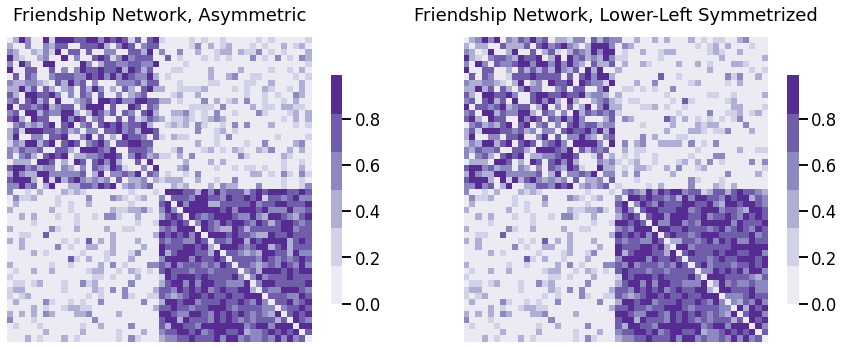

In [128]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(A_friend, ax=axs[0], title="Friendship Network, Asymmetric")
heatmap(A_friend_lowleft_sym, ax=axs[1], title="Friendship Network, Lower-Left Symmetrized")
fig;

#### Taking a function of the two values

There are many other ways we can also take a function of $a_{ij}$ and $a_{ji}$ to get a symmetric matrix. One is to just average the two. That is, we can let the matrix $A'$ be the matrix with entries $a'_{ij} = \frac{a_{ij} + a_{ji}}{2}$ for all $i$ and $j$. In matrix form, this operation looks like this:

\begin{align*}
    A' &= \frac{1}{2} (A + A^\top) \\
    &= \frac{1}{2}\left(\begin{bmatrix}
        a_{11} & ... & a_{1n} \\
        \vdots & \ddots & \vdots \\
        a_{n1} & ... & a_{nn}
    \end{bmatrix} + \begin{bmatrix}
        a_{11} & ... & a_{n1} \\
        \vdots & \ddots & \vdots \\
        a_{1n} & ... & a_{nn}
    \end{bmatrix}\right)\\
    &= \begin{bmatrix}
        \frac{1}{2}(a_{11} + a_{11}) & ... & \frac{1}{2}(a_{1n} + a_{n1}) \\
        \vdots & \ddots & \vdots \\
        \frac{1}{2} (a_{n1} + a_{1n}) & ... & \frac{1}{2}(a_{nn} + a_{nn})
    \end{bmatrix} \\
    &= \begin{bmatrix}
        a_{11} & ... & \frac{1}{2}(a_{1n} + a_{n1}) \\
        \vdots & \ddots & \vdots \\
        \frac{1}{2} (a_{n1} + a_{1n}) & ... & a_{nn}
    \end{bmatrix}
\end{align*}
As we can see, for all of the entries, $a'_{ij} = \frac{1}{2} (a_{ij} + a_{ji})$, and also $a_{ji}' = \frac{1}{2}(a_{ji} + a_{ij})$. These quantities are the same, so $a_{ij}' = a_{ji}'$, and $A'$ is symmetric. As the adjacency matrix is symmetric, the network that $A'$ represents is undirected.

Remember that the asymmetry in the friendship network means student $i$ might perceive their friendship with student $j$ as being stronger or weaker than student $j$ perceived about student $i$. What we did here was instead of just arbitrarily throwing one of those values away, we said that their friendship might be better indicated by averaging the two values. This produced for us a single friendship strength $a_{ij}'$ where $a_{ij}' = a_{ji}'$.

We can implement this in graspologic as follows:

In [129]:
# symmetrize with averaging
A_friend_avg_sym = symmetrize(A_friend, method="avg")

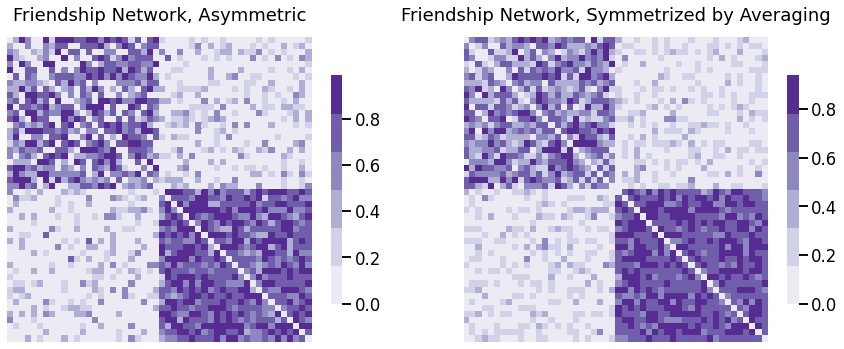

In [130]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(A_friend, ax=axs[0], title="Friendship Network, Asymmetric")
heatmap(A_friend_avg_sym, ax=axs[1], title="Friendship Network, Symmetrized by Averaging")
fig;

We will use the friendship network symmetrized by averaging going forward in our examples.

### Lowering edge bias

As you are probably aware, in all of machine learning, we are always concerned with the *bias/variance tradeoff*. The [**bias/variance tradeoff**](https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/#:~:text=Bias%20is%20the%20simplifying%20assumptions,change%20given%20different%20training%20data.) is an unfortunate side-effect that concerns how well a learning technique will generalize to new datasets. 
1. **Bias** is a simplifying assumption of a model that makes the task easier to estimate. For instance, if we have a friendship network, we might make simplifying assumptions, such as an assumption that two athletes frorm different sports have an equally likely chance of being friends with a member of the band. 
2. On the other hand, the **variance** is the degree to which the an estimate of a task will change when given new data. An assumption that if a player is a football player he has a higher chance of being friends with a band member might make sense given that the band performs at football games. 

The "trade-off" is that these two factors tend to be somewhat at odds, in that raising the bias tends to lower the variance, and vice-versa:

1. **High bias, but low variance**: Whereas a lower variance model might be better suited to the situation when the data we expect to see is noisy, it might not as faithfully represent the underlying dynamics we think the network possesses. A low variance model might ignore that athletes might have a different chance of being friends with a band member based on their sport all together. This means that while we won't get the student relationships *correct*, we might still be able to get a reasonable estimate that we think is not due to overfitting.
2. **Low bias, but high variance**: Whereas a low bias model might more faithfully model true relationships in our training data, it might fit our training data a little *too* well. Fitting the training data too well is a problem known as **overfitting**. If we only had three football team members and tried to assume that football players were better friends with band members, we might not be able to well approximate this relationship because of how few individuals we have who reflect this situation.

Here, we show several strategies to reduce the bias due to edge weight noise in network machine learning.

### Thresholding converts weighted networks to binary networks

The simplest way to reduce edge bias is the process of *thresholding*. Through thresholding, we choose a threshold value, $t$. Next, we simply set all of the entries of the adjacency matrix less than or equal to $t$ to zero, and the entries of the adjacency matrix above $t$ to one.

Some of the most common approaches to choosing this threshold are:

1. Set the threshhold to zero: set all non-zero weighted entries to one, and all zero-weight entries to zero. This is most commonly used when we see zero-inflated networks, or networks where the adjacency matrix takes values that are either zero or some quantity different from one, 
2. Set te threshold to be the mean: set all values below the mean edge-weight to zero, and all values above the mean edge-weight to one,
3. Use a quantile: A quantile is a percentile divided by $100$. In this strategy, we identify a target quantile of the edge-weight distribution. What this means is that we are selecting the lowest *fraction* of the edge-weights (where that fraction is the quantile that we choose) and setting these edges to $0$, and selecting the remaining edges to $1$. If we select a quantile of $0.5$, this means that we take the smallest $50\%$ of edges and set them to zero, and the largest $50\%$ of edges and set them to $1$.

We will show how to use the percentile approach to binarization, with both our activity/hobby and friendship networks. We will threshold using the edge-weight in the $50^{th}$ percentile. Our example networks of activity/hobby and friendship were loopless, as you could see above. Remember as we learned in the preceding section, that if the network itself is loopless, the diagonal entries simply *do not exist*; $0$ is simply a commonly used placeholder. For this reason, when we compute percentiles of edge-weights, we need to *exclude the diagonal*. Further, since this network is undirected, we also need to restrict our attention to one triangle of the corresponding adjacency matrix. We choose the upper-right triangle arbitrarily, as the adjacency matrix's symmetry means the upper-right triangle and lower-right triangle have identical edge-weight distributions. We begin by using this procedure on the friendship network. To complete this processs, we first look at the edge-weight distribution for the friendship network, which is shown below, and identified the edge-weight at the $0.5$ quartile:

In [144]:
# find the indices which are in the upper triangle and not in the diagonal
upper_tri_non_diag_idx = np.where(np.triu(np.ones(A_friend_avg_sym.shape), k=1).astype(bool))
t = np.quantile(A_friend_avg_sym[upper_tri_non_diag_idx], q=0.5)

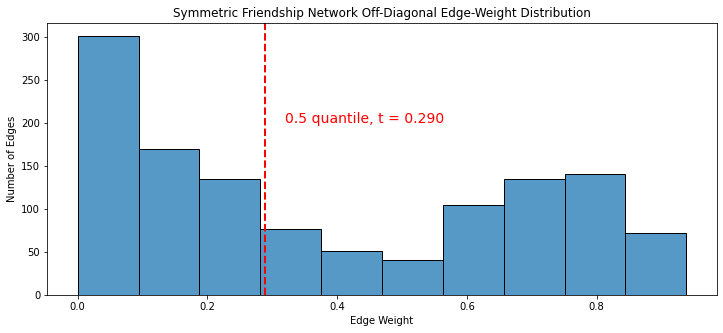

In [146]:
from seaborn import histplot

fig, axs = plt.subplots(1,1, figsize=(12, 5))
ax = histplot(A_friend_avg_sym[upper_tri_non_diag_idx].flatten(), ax=axs, bins=10)
ax.set_xlabel("Edge Weight");
ax.set_ylabel("Number of Edges");
ax.set_title("Symmetric Friendship Network Off-Diagonal Edge-Weight Distribution");
ax.axvline(t, color="red", linestyle="dashed", linewidth=2)
plt.text(t + .03, 200, "0.5 quantile, t = {:.3f}".format(t), fontsize=14, color="red");

The $0.5$ quantile, it turns out, is about $0.3$. This is because about $50\%$ of the edges are less than this threshold, and about $50\%$ of the edges are greater than this threshold. There is exactly one more edge in less than or equal to $t$, because this edge is exactly the median (an alternative name for the $0.5$ quartile) value:

In [147]:
print("Number of edges less than or equal to t: {}".format(np.sum(A_friend_avg_sym[upper_tri_non_diag_idx] <= t)))
print("Number of edges greater than or equal to t: {}".format(np.sum(A_friend_avg_sym[upper_tri_non_diag_idx] > t)))

Number of edges less than or equal to t: 613
Number of edges greater than or equal to t: 612


Next, we will assign the edges less than or equal to $t$ to zero, and the edges greater than or equal to $t$ to one:

In [148]:
A_friend_thresh = copy(A_friend_avg_sym)  # copy the network over

# threshold using t
A_friend_thresh[A_friend_thresh <= t] = 0
A_friend_thresh[A_friend_thresh > t] = 1

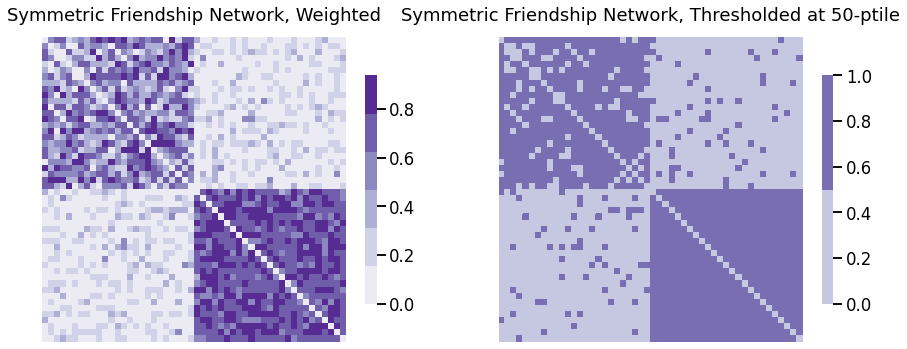

In [149]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(A_friend_avg_sym, ax=axs[0], title="Symmetric Friendship Network, Weighted")
heatmap(A_friend_thresh, ax=axs[1], title="Symmetric Friendship Network, Thresholded at 50-ptile")
fig;

Since the friendship network is now undirected (we made the adjacency matrix symmetric through averaging), loopless (because we defined it that way), and binary (because we thresholded the edges), we have now turned it into a *simple* network! Great job. Next, we will discuss an important property as to *why* thresholding using a quantile tends to be a very common tactic to obtaining simple networks from networks which are undirected and loopless. Remember that in the last section, we defined the network density for a simple network as:

\begin{align*}
    density(A) &= \frac{2\sum_{j > i}a_{ij}}{n(n - 1)}.
\end{align*}

Since we have thresholded at the $50^{th}$ percentile for the symmetric friendship network, this means that about $50$ percent of the possible edges will exist (the *largest* $50$ percent of edges), and $50$ percent of the possible edges will not exist (the *smallest* $50$ percent of edges). Remembering that the number of possible edges was $\frac{1}{2}n(n - 1)$ for an undirected network, this means that $\sum_{j > i}a_{ij}$ must be half of $\frac{1}{2}n(n - 1)$, or $\frac{1}{4}n(n - 1)$. Therefore:
\begin{align*}
    density(A) &= \frac{2\sum_{j > i}a_{ij}}{n(n - 1)}, \\
    &= \frac{2\cdot \frac{1}{4}n(n - 1)}{n(n - 1)},\;\;\;\sum_{j > i}a_{ij} = \frac{1}{4}n(n - 1) \\
    &= 0.5.
\end{align*}
So when we threshold the network at a quantile $t$, we end up with a network of density also equal to $t$! Let's confirm that this is the case for our symmetric friendship network:

In [150]:
from graspologic.utils import is_unweighted, is_loopless, is_symmetric

def simple_network_dens(X):
    # make sure the network is simple
    if (not is_unweighted(X)) or (not is_loopless(X)) or (not is_symmetric(X)):
        raise TypeError("Network is not simple!")
    # count the non-zero entries in the upper-right triangle
    # for a simple network X
    nnz = np.triu(X, k=1).sum()
    # number of nodes
    n = X.shape[0]
    # number of possible edges is 1/2 * n * (n-1)
    poss_edges = 0.5*n*(n-1)
    return nnz/poss_edges

print("Network Density: {:.3f}".format(simple_network_dens(A_friend_thresh)))

Network Density: 0.500


This is desirable for network machine learning because many network properties (such as the summary statistics we have discussed so far, and numerous other properties we will discuss in later chapters) can vary when the network density changes. This means that a network of a different density might have a higher clustering coefficient than a network of a lower density simply due to the fact that its density is higher (and therefore, there are more opportunities for closed triangles because each node has more connections). This means that when we threshold groups of networks and compare them, thresholding using a quantile will be very valuable. 

Note that a common pitfall you might run into with thresholding (and the broader class of techniques known as *sparsification* approaches) that rely on quantiles occurs when a weighted network can only take non-negative edge-weights. This corresponds to a network with an adjacency matrix $A$ where every $a_{ij}$ is greater than or equal to $0$. In this case, one must be careful to choose a threshold which is not zero. Let's consider a network were $60\%$ of the entries are zeros, and $40\%$ of the entries take a random value between $5$ and $10$:

In [151]:
from graspologic.simulations import er_nm

# 10 nodes
n = 10
# total number of edges is 40% of the number of possible edges
# 1/2 * n * (n-1)
m = int(0.4*0.5*n*(n-1))
A = er_nm(n, m, wt=np.random.uniform, wtargs=dict(low=5, high=10))

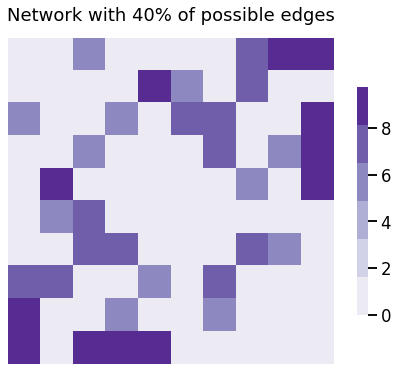

In [152]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))

heatmap(A, ax=axs, title="Network with 40% of possible edges");

If we threshold at the $50^{th}$ percentile, since $60$ percent of the edges do not exist, then the $50^{th}$ percentile is still just zero:

In [153]:
# use the quantile function to obtain the threshold
t = quantile(A[np.where(np.triu(A.shape, k=1))], q=0.5)  # quantile = percentile / 100
A_thresh = copy(A)  # copy the network over

# threshold using t
A_thresh[A_thresh <= t] = 0
A_thresh[A_thresh > t] = 1
print("Threshold for 50th percentile: {:d}".format(int(t)))

Threshold for 50th percentile: 0


And we don't actually end up with a network having a density of $0.5$, but rather, the same as the fraction of non-zero edges in the original network (which was $40\%$, or $0.4$):

In [154]:
dens = simple_network_dens(A_thresh)

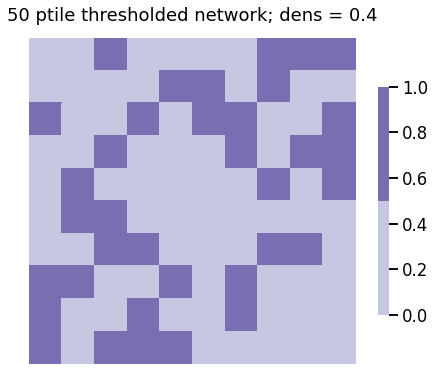

In [155]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))

heatmap(A_thresh, ax=axs, title="50 ptile thresholded network; dens = {:.1f}".format(dens));

So the take-home message is that we need to be careful that if we want to conclude that two percentile-thresholded networks have the same network density (equal to the percentile we thresholded at), that we have enough non-zero entries to threshold with across both (or all) of the networks.

### Sparsification removes potentially spurious low-weight edges

The next simplest edge-weight regularization technique is called *sparsificiation*. Remember that our alien brain looked like this:

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))

heatmap(Aa, ax=ax, title="Alien Brain Network");

Notice that for a *lot* of the off-diagonal entries, many of the values are really tiny compared to the maximum value in the network which is almost $40$. What if the way we measured these edges was very sensitive to high values, but had trouble discerning whether a value was actually zero, or was just really small?

For this particular situation, we turn to *sparsification*. Through sparsification, we proceed very similar to thresholding like we did above. Remember that we chose a threshold, $t$, and first set all adjacency values less than or equal to $t$ to zero. Now, we're done! We simply skip the step of setting values greater than $t$ to one. Let's try an example where we take the alien network, and sparsify the network using the $70^{th}$ percentile. Note that this will lead to the smallest $70$ percent of edges to take the value of zero, and the largest $30$ percent of edges will keep their original edge-weights:

In [ ]:
p = 70  # the percentile to sparsify with

# use the quantile function to obtain the threshold
t = quantile(Aa[non_diag_idx], q=p/100)  # quantile = percentile / 100
Aa_sparse = copy(Aa)  # copy the network over

# sparsify using t
Aa_sparse[Aa_sparse <= t] = 0

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Aa, ax=axs[0], title="Alien Brain Network")
heatmap(Aa_sparse, ax=axs[1], title="Alien Brain Network, Sparsified at 70th ptile");

Notice that many of the small entries in the off-diagonal areas now have a value of zero. Again, we have the same pitfalls for sparsification as we did with thresholding, where if the network takes only non-negative edge weights and the percentile we choose corresponds to a threshold of zero, we might not actually end up changing anything.

### Diagonal augmentation

https://github.com/microsoft/graspologic/blob/f9c4353488e29d367dec62fdb4729e6a7344fd89/graspologic/embed/ase.py#L58

### Edge-weight normalization

With weighted networks, it is often the case that we might want to reshape the distributions of edge-weights in our networks to highlight particular properties. Notice that the edge-weights for our human networks take values between $0$ and $1$, but for our alien network take values between $0$ and almost $40$. How can we possibly compare between these two networks when the edge-weights take such different ranges of values? We turn to standardization, which allows us to place values from different networks on the same scale. 

#### $z$-scoring standardizes edge weights using the normal distribution

The first approach to edge-weight standardization is known commonly as $z$-scoring. Suppose that $A$ is the adjacency matrix, with entries $a_{ij}$. With a $z$-score, we will rescale the weights of the adjacency matrix, such that the new edge-weights (called $z$-scores) are approximately normally distributed. The reason this can be useful is that the normal distribution is pretty ubiquitous across many branches of science, and therefore, a $z$-score is relatively easy to communicate with other scientists. Further, many things that exist in nature can be well-approximated by a normal distribution, so it seems like a reasonable place to start to use a $z$-score for edge-weights, too! The $z$-score is defined as follows. We will construct the $z$-scored adjacency matrix $Z$, whose entries $z_{ij}$ are the corresponding $z$-scores of the adjacency matrix's entries $a_{ij}$. For a weighted, loopless network, we use an estimate of the *mean*, $\hat \mu$, and the *unbiased* estimate of the *variance*, $\hat \sigma^2$), which can be computed as follows:
\begin{align*}
    \hat\mu &= \frac{1}{n}\sum_{i \neq j}a_{ij},\\
    \hat\sigma^2 &= \frac{1}{n - 1}\sum_{i \neq j} (a_{ij} - \hat\mu)^2.
\end{align*}
The $z$-score for the $(i,j)$ entry is simply the quantity:
\begin{align*}
    z_{ij} &= \frac{a_{ij} - \hat\mu}{\hat\sigma}
\end{align*}
Since our network is loopless, notice that these sums are for all *non-diagonal* entries where $i \neq j$. If the network were not loopless, we would include diagonal entries in the calculation, and instead would sum over all possible combinations of $i$ and $j$. the interpretation of the $z$-score $z_{ij}$ is the *number of stadard deviations* that the entry $a_{ij}$ is from the mean, $\hat \mu$.

We will demonstrate on the network where $40\%$ of the entries took a value between $5$ and $10$, and the other $60\%$ took a value of zero. We can implement $z$-scoring as follows:

In [ ]:
from scipy.stats import zscore
from numpy import zeros

def z_score_loopless(X):
    if not is_loopless(X):
        raise TypeError("The network has loops!")
    # the entries of the adjacency matrix that are not on the diagonal
    non_diag_idx = where(~eye(X.shape[0], dtype=bool))
    Z = zeros(X.shape)
    Z[non_diag_idx] = zscore(X[non_diag_idx])
    return Z

ZA = z_score_loopless(A)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(A, ax=axs[0], title="Network with 40% of possible edges")
heatmap(ZA, ax=axs[1], title="Network with 40% of possible edges, After Z-score");

Next, we will look at the edge-weight histogram for the alien brain network before and after $z$-scoring. An edge-weight histogram is a histogram which indicates the number of edges with weights falling in between a pair of values. Remember that the network is loopless, so again we exclude the diagonal entries:

In [ ]:
from seaborn import histplot

non_diag_idx = where(~eye(Aa.shape[0], dtype=bool))
fig, axs = plt.subplots(1,2, figsize=(15, 4))
ax = histplot(A.flatten(), ax=axs[0], bins=9)
ax.set_xlabel("Edge Weight");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, Before Z-score");
ax = histplot(ZA.flatten(), ax=axs[1], bins=9)
ax.set_xlabel("Z-score");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, After Z-score");

The theory for when, and why, to use $z$-scoring for network machine learning tends to go something like this: many things tend to be normally distributed with the same mean and variance, so perhaps that is a reasonable expectation for our network, too. Unfortunately, we find this often to *not* be the case. In fact, we often find that the specific distribution of edge weights itself often might be lamost infeasible to identify in a population of networks, and therefore *almost* irrelevant all-together. To this end, we turn to instead *ranking* the edges.

#### Ranking edges preserves ordinal relationships

The idea behind ranking is as follows. We don't really know much useful information as to how the distribution of edge weights varies between a given pair of networks. For this reason, we want to virtually eliminate the impact of that distribution *almost* entirely. However, we know that if one edge-weight is larger than another edge-weight, that we do in fact trust that relationship. What this means is that we want something which preserves *ordinal* relationships in our edge-weights, but ignores other properties of the edge-weights. An ordinal relationship just means that we have a natural ordering to the edge-weights. This means that we can identify a largest edge-weight, a smallest edge-weight, and every position in between. When we want to preserve ordinal relationships in our network, we do something called *passing the non-zero edge-weights to ranks*. We will often use the abbreviation `ptr` to define this function because it is so useful for weighted networks. We pass non-zero edge-weights to ranks as follows:

1. Identify all of the non-zero entries of the adjacency matrix $A$.
2. Count the number of non-zero entries of the adjacency matrix $A$, $n_{nz}$.
3. Rank all of the non-zero edges in the adjacency matrix $A$, where for a non-zero entry $a_{ij}$, $rank(a_{ij}) = 1$ if $a_{ij}$ is the smallest non-zero edge-weight, and $rank(a_{ij}) = n_{nz}$ if $a_{ij}$ is the largest edge-weight. Ties are settled by using the average rank of the two entries.
3. Report the weight of each non-zero entry $(i,j)$ as $r_{ij} = \frac{rank(a_{ij})}{n_{nz} + 1}$, and for eachh zero entry as $r_{ij} = 0$.

Below, we pass-to-ranks for the network with $40\%$ of the possible edges taking a value between $5$ and $10$, and the other $60\%$ taking a value of $0$ using `graspologic`:

In [ ]:
from graspologic.utils import pass_to_ranks

RA = pass_to_ranks(A)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(A, ax=axs[0], title="Network with 40% of possible edges")
heatmap(RA, ax=axs[1], title="Network with 40% of possible edges, After PTR", vmin=0, vmax=1);

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 4))
ax = histplot(A.flatten(), ax=axs[0], bins=9)
ax.set_xlabel("Edge Weight");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, Before PTR");
ax = histplot(RA.flatten(), ax=axs[1], binrange=[0, 1], bins=9)
ax.set_xlabel("normalized rank");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, After PTR");

The edge-weights for the adjacency matrix $R$ after `ptr` has the interpretataion that each entry $r_{ij}$ is the *quantile* of that entry amongst the other non-zero entries. This is unique in that it is completely *distribution-free*, which means that we don't need to assume anything about the distribution of the edge-weights to have a reasonably interpretable quantity. On the other hand, the $z$-score had the interpretation of the number of standard deviations from the mean, which is only a sensible quantity to compare if we assume the population of edge-weights are normally distributed.

Another useful quantity related to pass-to-ranks is known as the zero-boosted pass-to-ranks. Zero-boosted pass-to-ranks is conducted as follows:

1. Identify all of the non-zero entries of the adjacency matrix $A$.
2. Count the number of non-zero entries of the adjacency matrix $A$, $n_{nz}$, *and* the number of zero-entries of the adjacency matrix $A$, $n_z$. Note that since the values of the adjacency matrix are either zero or non-zero, that $n_{nz} + n_z = n^2$, as $A$ is an $n \times n$ matrix and therefore has $n^2$ total entries.
3. Rank all of the non-zero edges in the adjacency matrix $A$, where for a non-zero entry $a_{ij}$, $rank(a_{ij}) = 1$ if $a_{ij}$ is the smallest non-zero edge-weight, and $rank(a_{ij}) = n_{nz}$ if $a_{ij}$ is the largest edge-weight. Ties are settled by using the average rank of the two entries.
3. Report the weight of each non-zero entry $(i,j)$ as $r_{ij}' = \frac{n_z + rank(a_{ij})}{n^2 + 1}$, and for each zero entry as $r_{ij}' = 0$.

The edge-weights for the adjacency matrix $R'$ after zero-boosted `ptr` have the interpretation that each entry $r_{ij}'$ is the quantile of that entry amongst *all* of the entries. Let's instead use zero-boosted `ptr` on our network:

In [ ]:
RAzb = pass_to_ranks(A, method="zero-boost")

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 4))
ax = histplot(A.flatten(), ax=axs[0], bins=9)
ax.set_xlabel("Edge Weight");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, Before zb-PTR");
ax = histplot(RAzb.flatten(), ax=axs[1], binrange=[0, 1], bins=23)
ax.set_xlabel("normalized rank");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, After zb-PTR");

#### Logging reduces magnitudinal differences between edges

When we look at the distribution of non-zero edge-weights for the alien brain network, we notice a weird behavior, known as a *right-skew*:

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax = histplot(Aa.flatten(), ax=ax, bins=20)
ax.set_xlabel("Edge Weight");
ax.set_ylabel("Number of Edges");

Notice that *most* of the edges havae weights which are comparatively small, between $0$ and $10$, but some of the edges have weights which are much (much) larger. A **right-skew** exists when the majority of edge-weights are small, but some of the edge-weights take values which are much larger. 

What if we want to make these large values more similar in relation to the smaller values, but we simultaneously want to preserve properties of the underlying distribution of the edge-weights? Well, we can't use `ptr`, because `ptr` will throw away all of the information about the edge-weight distribution other than the ordinal relationship between pairs of edges. To do this, we instead turn to the logarithm function. The logarithm function $log_{10}(x)$ is defined for positive values $x$ as the value $c_x$ where $x = 10^{c_x}$. In this sense, it is the "number of powers of ten" to obtain the value $x$. You will notice that the logarithm function looks like this:

In [ ]:
import numpy as np
import seaborn as sns

xs = np.linspace(0.001, 100, num=1000)
logxs = np.log10(xs)

fig, ax = plt.subplots(1,1, figsize=(8, 6))
sns.lineplot(xs, logxs, ax=ax)
ax.axhline(0, color="red")
ax.set_xlabel("x")
ax.set_ylabel("$log_{10}(x)$");

What is key to noice about this function is that, as $x$ increases, the log of $x$ increases by a *decreasing* amount. Let's imagine we have three values, $x = .001$, $y = .1$, and $z = 10$. A calculator will give you that $log_{10}(x) = -3, log_{10}(y) = -1$, and $log_{10}(z) = 1$. Even though $y$ is only $.099$ units bigger than $x$, its logarithm $log_{10}(y)$ exceeds $log_{10}(x)$ by two units. on the other hand, $z$ is $9.9$ units bigger than $y$, but yet its logarithm $log_{10}(z)$ is still the same two units bigger than $log_{10}(y)$. This is because thhe logarithm is instead looking at the fact that $z$ is *one* power of ten, $y$ is $-1$ powers of ten, and $z$ is $-3$ powers of ten. The logarithm has *collapsed* the huge size difference between $z$ and the other two values $x$ and $y$ by using exponentiation. 

In this sense, we can also use the logarithm function for our network to reduce the huge size difference between the values in our alien network. However, we must first add a slight twist: to do this properly and yield an interpretable adjacency matrix, we need to *augment* the entries of the adjacency matrix *if* it contains zeros. This is because the $log_{10}(0)$ is *not defined*. To augment the adjacency matrix, we will use the following strategy:

1. Identify the entries of $A$ which take a value of zero.
2. Identify the smallest entry of $A$ which is not-zero, and call it $a_m$.
3. Compute a value $\epsilon$ which is an *order of magnitude* smaller than $a_m$. Since we are taking powers of ten, a single order of magnitude would give us that $\epsilon = \frac{a_m}{10}$. 
4. Take the augmented adjacency matrix $A'$ to be defined with entries $a_{ij}' = a_{ij} + \epsilon$.

Next, since our matrix has values which are now all greater than zero, we can just take the logarithm:

In [ ]:
def augment_zeros(X):
    if np.any(X < 0):
        raise TypeError("The logarithm is not defined for negative values!")
    am = np.min(X[np.where(X > 0)])  # the smallest non-zero entry of X
    eps = am/10  # epsilon is one order of magnitude smaller than the smallest non-zero entry
    return X + eps  # augment all entries of X by epsilon

Aa_aug = augment_zeros(Aa)
# log-transform using base 10
Aa_log = np.log10(Aa_aug)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Aa, ax=axs[0], title="Alien Brain Network")
heatmap(Aa_log, ax=axs[1], title="Alien Brain Network, After Augmentation + log");

When we plot the augmented and log-transformed data, what we see is that many of the edge-weights we originally might have thought were zero if we only looked at a plot were, in actuality, *not* zero. In this sense, for non-negative weighted networks, log transforming after zero-augmentation is often very useful for visualization to get a sense of the magnitudinal differences that might be present between edges.

Our edge-weight histogram becomes:

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax = histplot(Aa_log.flatten(), ax=ax, bins=11)
ax.set_xlabel("$log_{10}($Edge Weight$ + \epsilon)$");
ax.set_ylabel("Number of Edges");